# Analyzing replicability of connectivity-based multivariate BWAS on the Human Connectome Project dataset

## Imports

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
sns.set(rc={"figure.figsize":(4, 2)})
sns.set_style("whitegrid")

## Load HCP data

We load functional network matrices (netmats) from the HCP1200-release, as published on connectomeDB: https://db.humanconnectome.org/
Due to licensoing issues, data is not supplied with the repository, but can be downloaded from the ConnectomeDB.
See [hcp_data/readme.md](hcp_data/readme.md) for more details.

array([[<AxesSubplot:title={'center':'motion'}>]], dtype=object)

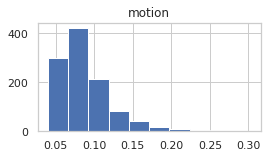

In [54]:
motion = pd.read_csv('hcp_data/motion.csv', index_col=0).set_index('ID', drop=True, inplace=False)
motion.hist()

In [55]:
# HCP data can be obtained from the connectomeDB
# data is not part of this repository
subjectIDs = pd.read_csv('hcp_data/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('hcp_data/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('hcp_data/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('hcp_data/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# add motion
behavior = behavior.merge(motion, left_index=True, right_index=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,motion,age
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,0.057224,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,0.065499,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,0.098191,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,0.101858,28.0
101006,S500,Q06,F,31-35,True,2,2,4,100.0,True,...,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80,0.086306,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,0.071538,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,0.084067,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,0.083142,28.0
995174,S1200,Q13,M,22-25,False,1,1,2,0.0,True,...,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80,0.094121,23.5


# Function to prepare target variable


In [69]:
def create_data(target='CogTotalComp_AgeAdj', feature_data=netmats_parcor, motion_threshold = 0.2, sample_size=None, random_state=None):
    # it's a good practice to use pandas for merging, messing up subject order can be painful
    features = feature_data.columns
    df = behavior
    df = df.merge(feature_data, left_index=True, right_index=True, how='left')

    df = df.dropna(subset = [target] + features.values.tolist())
    df = df[df.motion <= motion_threshold]

    if sample_size:
        df = df.sample(sample_size, replace=False, random_state=random_state)

    y = df[target].values
    X = df[features].values

    return X, y

In [70]:
def bootstrap_workhorse(model, target, feature_data, motion_threshold, sample_size, random_state):
    X, y = create_data(target=target, feature_data=feature_data, motion_threshold=motion_threshold, sample_size=sample_size, random_state=random_state)

    predicted_discovery_cv = np.zeros_like(y)
    i = 0
    cv = KFold(10, shuffle=True, random_state=random_state)
    cor_per_fold = np.zeros(cv.n_splits)
    for train, test in cv.split(X=X, y=y):
        model.fit(X=X[train], y=y[train])
        predicted_discovery_cv[test] = model.predict(X=X[test])
        cor_per_fold[i] = np.corrcoef(y[test], predicted_discovery_cv[test])[0,1]
        i += 1
    # correlation between the cross-validated predictions and observations in the discovery sample
    # this is the correct, unbiased estimate!
    # calculated as mean test performance across all folds
    r_disc_cv = np.mean(cor_per_fold)
    return r_disc_cv


In [81]:
model = Ridge()
feature_data = netmats_parcor

random_state = 42

targets = []
motion_thrs = []
cv_rs = []

n_bootstrap = 100
motion_thresholds = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, motion.max().values[0]]

for target_var in ['age', 'CogTotalComp_AgeAdj', 'PMAT24_A_CR', 'Flanker_AgeAdj', 'CardSort_AgeAdj', 'PicSeq_AgeAdj']:

    # obtain smalles sample size
    X, y = create_data(target=target_var, feature_data=netmats_pearson, motion_threshold=min(motion_thresholds))
    sample_size = len(y)

    for motion_thr in motion_thresholds:
        print(target_var, motion_thr)

        # create random seeds for each bootstrap iteration for reproducibility
        rng = np.random.default_rng(random_state)
        random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)
        # run bootstrap iterations in parallel
        r = Parallel(n_jobs=-1)(delayed(bootstrap_workhorse)(model=model, target=target_var, feature_data=feature_data, motion_threshold=motion_thr, sample_size=sample_size, random_state=seed) for seed in random_sates)


        targets += [target_var]*n_bootstrap
        motion_thrs += [motion_thr]*n_bootstrap
        cv_rs += r
        mean_r = np.mean(r)

        print('r =', np.round(mean_r, 2), '\tR2 =', np.round(mean_r**2 * 100, 1),  '%')

df = pd.DataFrame({
    'target': targets,
    'motion threshold': motion_thrs,
    'r': cv_rs
})

age 0.1
r = 0.52 	R2 = 26.8 %
age 0.12
r = 0.51 	R2 = 26.3 %
age 0.14
r = 0.51 	R2 = 26.0 %
age 0.16
r = 0.5 	R2 = 24.6 %
age 0.18
r = 0.51 	R2 = 25.9 %
age 0.2
r = 0.51 	R2 = 26.0 %
age 0.22
r = 0.51 	R2 = 26.0 %
age 0.24
r = 0.51 	R2 = 26.1 %
age 0.26
r = 0.51 	R2 = 26.4 %
age 0.302853
r = 0.51 	R2 = 26.2 %
CogTotalComp_AgeAdj 0.1
r = 0.48 	R2 = 22.9 %
CogTotalComp_AgeAdj 0.12
r = 0.47 	R2 = 21.7 %
CogTotalComp_AgeAdj 0.14
r = 0.48 	R2 = 23.0 %
CogTotalComp_AgeAdj 0.16
r = 0.48 	R2 = 22.9 %
CogTotalComp_AgeAdj 0.18
r = 0.49 	R2 = 23.8 %
CogTotalComp_AgeAdj 0.2
r = 0.48 	R2 = 23.4 %
CogTotalComp_AgeAdj 0.22
r = 0.49 	R2 = 23.8 %
CogTotalComp_AgeAdj 0.24
r = 0.49 	R2 = 24.1 %
CogTotalComp_AgeAdj 0.26
r = 0.49 	R2 = 24.1 %
CogTotalComp_AgeAdj 0.302853
r = 0.49 	R2 = 23.9 %
PMAT24_A_CR 0.1
r = 0.26 	R2 = 6.8 %
PMAT24_A_CR 0.12
r = 0.26 	R2 = 6.6 %
PMAT24_A_CR 0.14
r = 0.29 	R2 = 8.2 %
PMAT24_A_CR 0.16
r = 0.29 	R2 = 8.6 %
PMAT24_A_CR 0.18
r = 0.3 	R2 = 9.1 %
PMAT24_A_CR 0.2
r = 0.3 	R2 =

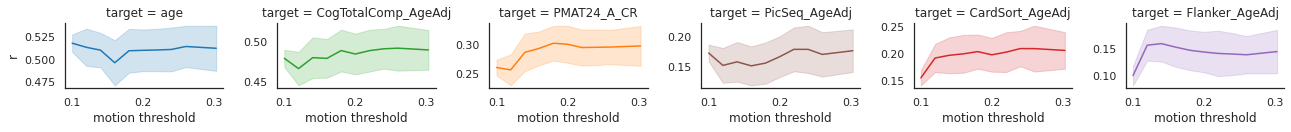

In [88]:
sns.set_style("white")

palette = {
    'age' : 'tab:blue',
    'CogTotalComp_AgeAdj' : 'tab:green',
    'PMAT24_A_CR' : 'tab:orange',
    'Flanker_AgeAdj' : 'tab:purple',
    'CardSort_AgeAdj' : 'tab:red',
    'PicSeq_AgeAdj' : 'tab:brown'
}

g = sns.FacetGrid(df, col="target", hue="target", height=2, aspect=1.5, palette=palette, sharey=False,
                  col_order=['age', 'CogTotalComp_AgeAdj', 'PMAT24_A_CR', 'PicSeq_AgeAdj', 'CardSort_AgeAdj', 'Flanker_AgeAdj'])
g.map(sns.lineplot, 'motion threshold', 'r', ci='sd')
#g.refline(y=0)
plt.savefig('fig/motion_dependence_parcor_Ridge_all.pdf')